Con este programa generamos un dataframe con datos de imagenes

In [59]:
import os

home = os.path.expanduser("~")

db_name=  'colab_main_dataset_21b' #'test_new_creators_4'
#input_dir = os.path.join(home, 'video_resources', 'image_datasets')
output_dir = os.path.join(home, 'video_resources', 'sql_database')
#output_dir = os.path.join(home, 'drive', '.shared','LR_face_video')
#database_names=['enfsi','lfw','forenface'] # 'lfw', 'scface',  'enfsi', 'enfsi2015', 'xqlfw', 'utkface','chokepoint','forenface'
#detector_names=['mtcnn'] # 'dlib', 'mtcnn', 'mtcnn_serfiq'
#embedding_model_names=["QMagFace"] # , "Dlib", "ArcFace",
#attributes_to_update=[]  # 'gender', 'age', 'emotion', 'race'
#quality_model_names = ['ser_fiq', 'tface'] # 'confusion_score', 'ser_fiq',

In [60]:
from sql_face.alchemy import get_session
session = get_session(output_dir, db_name)



In [61]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sql_face.tables import  QualityImage, FaceImage, CroppedImage, Image, QualityModel, QualityGroup,Detector, EmbeddingModel,EnfsiImage,EnfsiVideoFrame

# embedding Models QMagFace y QMagFace_SR
## Calibración:
- XQLFW
- UTKface
- SCFace
- ForenFace
## Test
- Enfsi (2015)


In [62]:
models = ['QMagFace','QMagFace_SR']
calibration = ['XQLFW','UTKface','SCFace','ForenFace']
test = []

In [63]:

results1 = session.query(Image,Detector.name,EmbeddingModel.name,QualityModel.name,QualityImage.quality_group,QualityImage.quality) \
                        .select_from(Image).filter(Image.source.in_(calibration) ) \
                        .join(CroppedImage).join(Detector).filter(CroppedImage.face_detected == True) \
                        .join(FaceImage).join(EmbeddingModel).filter(EmbeddingModel.name.in_(models)) \
                        .join(QualityImage).join(QualityModel) \
                        .filter(QualityImage.quality != None) \
                        .all() 
#.filter(EnfsiVideoFrame.yaw !=None)
#

In [64]:

results2 = session.query(Image,Detector.name,EmbeddingModel.name,QualityModel.name,QualityImage.quality_group,QualityImage.quality) \
                        .select_from(Image).filter(Image.type == 'enfsiImage',Image.path.like('%2015%')) \
                        .join(CroppedImage).join(Detector).filter(CroppedImage.face_detected == True) \
                        .join(FaceImage).join(EmbeddingModel).filter(EmbeddingModel.name.in_(models)) \
                        .join(QualityImage).join(QualityModel) \
                        .filter(QualityImage.quality != None) \
                        .all() 
#.filter(EnfsiVideoFrame.yaw !=None)

In [65]:
im_cols = ['identity', 'pitch', 'angle_pitch', 'yaw', 'angle_yaw', 'roll','angle_roll',
           'source', 'gender', 'headgear',  'age','age_number',
            'glasses', 'type',  'beard', 'emotion', 'other_occlusions',
            'race',  'image_id']
fixed_cols = ['Detector','E_Model','Q_Model','Q_group','Quality']

df1 = pd.DataFrame([ [getattr(r[0],attr)   for attr in im_cols]  + list(r[1:6])
                   for r in results1],
                   columns=im_cols + fixed_cols )
df2 = pd.DataFrame([ [getattr(r[0],attr)   for attr in im_cols]  + list(r[1:6])
                   for r in results2],
                   columns=im_cols + fixed_cols )

df = df1.append(df2)
df.reset_index(inplace=True)

df.to_pickle(os.path.join(output_dir,'df_colab_21b.pkl'))


In [66]:
df

,index,identity,pitch,angle_pitch,yaw,angle_yaw,roll,angle_roll,source,gender,...,beard,emotion,other_occlusions,race,image_id,Detector,E_Model,Q_Model,Q_group,Quality
0,0,060,Pitch.HALF_UP,None,Yaw.FRONTAL,None,Roll.FRONTAL,None,SCFace,Gender.MALE,...,False,Emotion.NEUTRAL,None,Race.WHITE,391,mtcnn,QMagFace,ser_fiq,QualityGroup.HIGH,0.692671
1,1,030,Pitch.HALF_DOWN,None,Yaw.FRONTAL,None,Roll.FRONTAL,None,SCFace,Gender.MALE,...,False,Emotion.NEUTRAL,None,Race.WHITE,392,mtcnn,QMagFace,ser_fiq,QualityGroup.VERY_LOW,0.003943
2,2,047,Pitch.DOWN,None,Yaw.FRONTAL,None,Roll.FRONTAL,None,SCFace,Gender.MALE,...,False,Emotion.NEUTRAL,None,Race.WHITE,393,mtcnn,QMagFace,ser_fiq,QualityGroup.HIGH,0.746437
3,3,014,Pitch.FRONTAL,None,Yaw.PROFILE,None,None,None,SCFace,Gender.FEMALE,...,False,Emotion.NEUTRAL,None,Race.WHITE,394,mtcnn,QMagFace,ser_fiq,QualityGroup.VERY_LOW,0.000380
4,4,035,Pitch.FRONTAL,None,Yaw.FRONTAL,None,Roll.HALF_LEANING,None,SCFace,Gender.MALE,...,True,Emotion.NEUTRAL,None,Race.WHITE,395,mtcnn,QMagFace,ser_fiq,QualityGroup.VERY_HIGH,0.861327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297795,1105,2015-7,Pitch.FRONTAL,0.567765,Yaw.PROFILE,-55.055234,Roll.FRONTAL,-3.960244,ENFSI,Gender.MALE,...,None,Emotion.FEAR,None,Race.WHITE,6019,mtcnn_serfiq,QMagFace_SR,ser_fiq,QualityGroup.MEDIUM,0.189554
297796,1106,2015-1,Pitch.HALF_UP,-13.37915,Yaw.FRONTAL,-7.0075,Roll.FRONTAL,1.321452,ENFSI,Gender.FEMALE,...,None,Emotion.NEUTRAL,None,Race.WHITE,4676,mtcnn_serfiq,QMagFace_SR,ser_fiq,QualityGroup.HIGH,0.734290
297797,1107,2015-1,Pitch.FRONTAL,-5.347922,Yaw.FRONTAL,-3.339354,Roll.FRONTAL,-0.575616,ENFSI,Gender.FEMALE,...,None,Emotion.ANGRY,None,Race.WHITE,4684,mtcnn_serfiq,QMagFace_SR,ser_fiq,QualityGroup.VERY_HIGH,0.794687
297798,1108,2015-14,Pitch.HALF_DOWN,2.94304,Yaw.PROFILE,44.091928,Roll.HALF_LEANING,7.73719,ENFSI,Gender.MALE,...,None,Emotion.HAPPY,None,Race.WHITE,7712,mtcnn_serfiq,QMagFace_SR,ser_fiq,QualityGroup.HIGH,0.728360


In [67]:
df.groupby(['source','Detector','E_Model']).size()

source     Detector      E_Model    
ENFSI      mediapipe     QMagFace         308
           mtcnn         QMagFace         328
           mtcnn_serfiq  QMagFace         316
                         QMagFace_SR      158
ForenFace  mediapipe     QMagFace        4398
           mtcnn         QMagFace        4742
           mtcnn_serfiq  QMagFace        4684
                         QMagFace_SR     2080
SCFace     mediapipe     QMagFace        8262
           mtcnn         QMagFace        7764
           mtcnn_serfiq  QMagFace        7682
                         QMagFace_SR     3841
UTKface    mediapipe     QMagFace       45314
           mtcnn         QMagFace       48092
           mtcnn_serfiq  QMagFace       47910
                         QMagFace_SR    23955
XQLFW      mediapipe     QMagFace       22228
           mtcnn         QMagFace       26318
           mtcnn_serfiq  QMagFace       26280
                         QMagFace_SR    13140
dtype: int64

<AxesSubplot: >

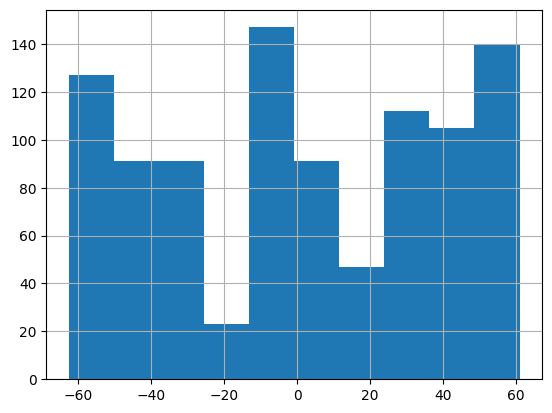

In [68]:
df.angle_yaw.hist()

In [58]:
df.source.value_counts()

UTKface      165271
XQLFW         87966
SCFace        27549
ForenFace     15904
ENFSI          1110
Name: source, dtype: int64